In [12]:
import h5py
import os
import warnings
import sys
from collections import defaultdict
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path += ["../vcf_utils"]
import utils

pd.set_option("display.max_columns", None)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# MAGE classification (panel A)

### Helper functions

In [13]:
MAGE_PATH = "causal_variants/MAGE_all/eQTL_finemapping.allAssociations.trainGenes.metadata.hg19.MAGE.v1.0.tsv"

FUSION_WEIGHTS_DIR = "../fusion/overall/WEIGHTS"
FUSION_MODELS = ["top1", "lasso", "enet", "blup", "bslmm"]
FINETUNED_MODEL_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/ism"
BASELINE_MODEL_ISM_DIR = "ISM/baseline.384_bins/"
RANDOM_INIT_MODEL_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_random_init_data_seed_42_lr_1e-05_wd_0.0001_rcprob_0.5_rsmax_3_random_init/ism"

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
TRAIN_H5_PATH = "../finetuning/data/h5_bins_384_chrom_split/train.h5"

In [14]:
model_renamings = {
    "random": "Pairwise Regression" + "\n" + "with random" + "\n" + "initialization", 
    "baseline": "Baseline Enformer",
    "finetuned": "Pairwise Regression",
    "top1": "Top SNP",
    "lasso": "LASSO",
    "enet": "Elastic net/" + "\n" + "PrediXcan",
    "blup": "BLUP",
    "bslmm": "BSLMM",
}

def rename_model(model: str) -> str:
    return model_renamings[model]

In [15]:
def get_train_samples_per_gene() -> dict[str, set]:
    gene_to_samples = defaultdict(set)
    with h5py.File(TRAIN_H5_PATH, "r") as f:
        genes = f["genes"][:].astype(str)
        samples = f["samples"][:].astype(str)
        for (g, s) in zip(genes, samples):
            gene_to_samples[g].add(s)
    return gene_to_samples


def get_common_variants_from_genotype_mtx(
    genotype_mtx: pd.DataFrame, maf_threshold: float = 0.05
) -> tuple[list[Variant], pd.Series]:
    ac = genotype_mtx.applymap(utils.convert_to_dosage).sum(axis=1)
    an = genotype_mtx.applymap(utils.count_total_alleles).sum(axis=1)
    af = ac / an
    variants_f = af[(af >= maf_threshold) & (af <= 1 - maf_threshold)].index
    return variants_f.tolist(), af

In [16]:
def load_fusion_weights(gene: str, model: str) -> pd.Series:
    fpath = os.path.join(FUSION_WEIGHTS_DIR, f"{gene}.{model}.weights.txt")
    df = pd.read_csv(fpath, sep="\t", header=None, names=["id", "alt", "ref", "weight"])
    df["weight"] = df["weight"].astype(float)
    
    if df.isnull().values.any():
        print(f"WARNING: NaNs detected in {fpath}")
        df = df.dropna()
    
    df["chrom"] = df["id"].apply(lambda x: x.split("_")[1])
    df["pos"] = df["id"].apply(lambda x: int(x.split("_")[2]))
    df["variant"] = [
        Variant(chr_, pos, ref, alt)
        for (chr_, pos, ref, alt)
        in zip(df["chrom"], df["pos"], df["ref"], df["alt"])
    ]
    df = df.set_index("variant")
    assert df["weight"].notnull().all()
    assert df["weight"].apply(lambda x: isinstance(x, float)).all()
    return df["weight"].abs()


def load_enformer_predictions(ism_dir: str, gene: str) -> pd.Series:
    fpath = os.path.join(ism_dir, f"{gene}.csv")
    df = pd.read_csv(fpath, header=0, index_col=0)
    df.index = df.index.map(Variant.create_from_str)
    assert df["variant"].isnull().sum() == 0
    assert df["ref"].isnull().sum() == 0
    return df["ISM"].abs()

In [17]:
def add_model_predictions(variants_df: pd.DataFrame, counts_df: pd.DataFrame) -> pd.DataFrame:
    train_samples_per_gene = get_train_samples_per_gene()

    def get_common_variants_for_gene(chrom: str, tss: int, train_samples: list[str]) -> list[Variant]:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            genotype_mtx = utils.get_genotype_matrix(chrom, tss, 128 * 384)
            common_variants, _ = get_common_variants_from_genotype_mtx(genotype_mtx[sorted(train_samples)])
            return common_variants
    
    genes = sorted(variants_df["our_gene_name"].unique())
    common_variants_res = Parallel(n_jobs=32)(
        delayed(get_common_variants_for_gene)
        (counts_df.loc[g, "Chr"], counts_df.loc[g, "Coord"], train_samples_per_gene[g])
        for g in genes
    )
    common_variants_per_gene = dict(zip(genes, common_variants_res))

    predictions_per_gene = defaultdict(dict)
    for gene in tqdm(variants_df["our_gene_name"].unique(), desc="Loading predictions per gene"):
        for model in FUSION_MODELS:
            scores = load_fusion_weights(gene, model)
            if model in ["blup", "bslmm"]:
                assert set(scores.index) == set(common_variants_per_gene[gene])
            else:
                assert set(scores.index).issubset(set(common_variants_per_gene[gene]))
                scores = scores.reindex(common_variants_per_gene[gene], fill_value=0.0)
            assert set(scores.index) == set(common_variants_per_gene[gene])
            percentiles = scores.rank(pct=True, method="average") * 100.0
            predictions_per_gene[gene][model] = percentiles

        for model in ["baseline", "finetuned", "random"]:
            if model == "random":
                ism_dir = RANDOM_INIT_MODEL_ISM_DIR
            elif model == "finetuned":
                ism_dir = FINETUNED_MODEL_ISM_DIR
            else:
                ism_dir = BASELINE_MODEL_ISM_DIR
            scores = load_enformer_predictions(ism_dir, gene)
            scores = scores.loc[common_variants_per_gene[gene]].copy()
            assert set(scores.index) == set(common_variants_per_gene[gene])
            percentiles = scores.rank(pct=True, method="average") * 100.0
            predictions_per_gene[gene][model] = percentiles
    
    predictions_per_model = defaultdict(list)
    for variant, gene in zip(variants_df["hg19_variant"], variants_df["our_gene_name"]):
        for model in FUSION_MODELS + ["baseline", "finetuned", "random"]:
            beta = predictions_per_gene[gene][model][variant]
            predictions_per_model[model].append(beta)
    
    # Add predictions to the dataframe
    for model in FUSION_MODELS + ["baseline", "finetuned", "random"]:
        variants_df[model] = predictions_per_model[model]
        assert variants_df[model].notnull().all()
    return variants_df

In [18]:
def create_classification_dataset(
    pos_df: pd.DataFrame,
    neg_df: pd.DataFrame,
    sampling_strategy: str = "random",
    n_closest: int = 10,
):
    neg_rows = []
    for i, (gene, hg19_variant) in enumerate(zip(pos_df["our_gene_name"], pos_df["hg19_variant"])):
        neg_gene_df = neg_df[neg_df["our_gene_name"] == gene].copy()
        assert len(neg_gene_df) > 0, f"No negative examples for gene {gene}"
        if sampling_strategy == "random":
            neg_row = neg_gene_df.sample(1).iloc[0]
        elif sampling_strategy == "closest":
            dist_to_pos = (neg_df["variant_hg19_pos"] - hg19_variant.pos).abs()
            closest_idx = dist_to_pos.idxmin()
            neg_row = neg_df.loc[closest_idx].copy()
        elif sampling_strategy == "random_among_closest":
            dist_to_pos = (neg_df["variant_hg19_pos"] - hg19_variant.pos).abs()
            closest_idxs = dist_to_pos.nsmallest(n_closest).index
            neg_row = neg_df.loc[closest_idxs].sample(1).iloc[0]
        else:
            raise ValueError(f"Unknown sampling strategy: {sampling_strategy}")
        neg_row["comparison_idx"] = i
        neg_rows.append(neg_row)
    neg_subset_df = pd.DataFrame(neg_rows)    
    neg_subset_df["label"] = 0

    pos_df = pos_df.copy()
    pos_df["label"] = 1
    pos_df["comparison_idx"] = np.arange(len(pos_df))
    classification_df = pd.concat([pos_df, neg_subset_df], ignore_index=True)
    return classification_df

### Analysis

In [19]:
counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")
mage_df = pd.read_csv(MAGE_PATH, sep="\t")
mage_df = mage_df[mage_df["in_training_set"]].copy()
mage_df["hg19_variant"] = mage_df["hg19_variant"].map(Variant.create_from_str)

/tmp/ipykernel_929275/4016454589.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  mage_df = pd.read_csv(MAGE_PATH, sep="\t")


In [20]:
mage_df = add_model_predictions(mage_df, counts_df)

Loading predictions per gene:   0%|          | 0/368 [00:00<?, ?it/s]

In [21]:
aurocs_per_model = defaultdict(list)
tprs_per_model = defaultdict(list) # Store TPRs corresponding to FPRs=np.arange(0, 1.01, 0.01)

pos_mage_df = mage_df[mage_df["variantPIP"] > 0.9].copy()
neg_mage_df = mage_df[mage_df["variantPIP"] < 1e-2].copy()

for _ in tqdm(range(100)):
    classification_df = create_classification_dataset(pos_mage_df, neg_mage_df, sampling_strategy="random")
    for model in FUSION_MODELS + ["baseline", "finetuned", "random"]:
        # Compute summary statistics
        auroc = roc_auc_score(classification_df["label"], classification_df[model])
        aurocs_per_model[model].append(auroc)
        # Compute full ROC curve
        fpr, tpr, _ = roc_curve(classification_df["label"], classification_df[model])
        tprs_per_model[model].append(np.interp(np.arange(0, 1.01, 0.01), fpr, tpr))

  0%|          | 0/100 [00:00<?, ?it/s]

# Enrichment of drivers in DNase I LCL footprints (panel B)

In [22]:
def rename_model_for_dnase1_enrichment_df(model: str) -> str:
    if model == "Pairwise Regression" + "\n" + "with random initialization":
        return "Pairwise Regression" + "\n" + "with random" + "\n" + "initialization"
    return model

dnase1_enrichment_df = pd.read_csv("drivers/dnase1_enrichment.csv")
dnase1_enrichment_df["model"] = dnase1_enrichment_df["model"].map(rename_model_for_dnase1_enrichment_df)

# Plot

/tmp/ipykernel_929275/2313129695.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, ha="center", fontsize=13)


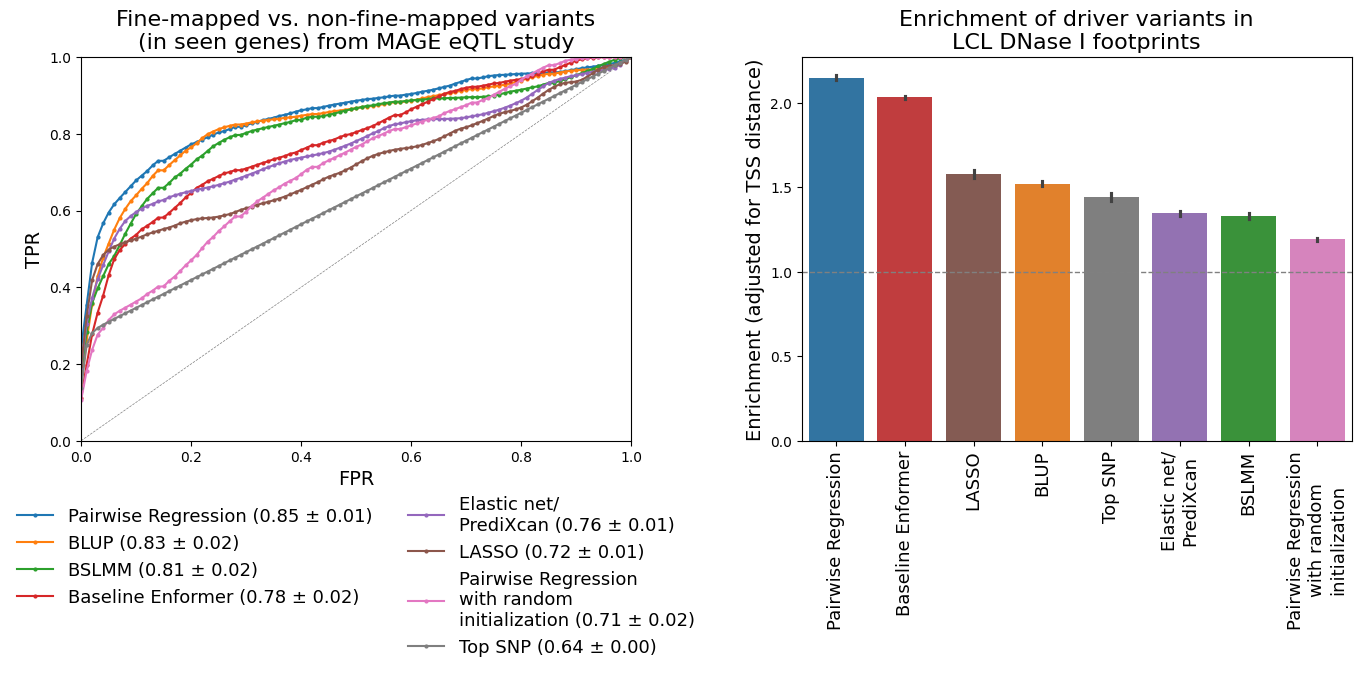

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))

# Panel A
sorted_models = sorted(aurocs_per_model, key=lambda x: np.mean(aurocs_per_model[x]), reverse=True)
model_to_color = dict(zip(sorted_models, sns.color_palette("tab10", len(sorted_models))))
renamed_model_to_color = {rename_model(model): color for model, color in model_to_color.items()}

for model in sorted(aurocs_per_model, key=lambda x: np.mean(aurocs_per_model[x]), reverse=True):
    fprs = np.arange(0, 1.01, 0.01)
    mean_tprs = np.mean(tprs_per_model[model], axis=0)
    mean_auroc = np.mean(aurocs_per_model[model])
    std_auroc = np.std(aurocs_per_model[model])
    axs[0].plot(
        fprs, 
        mean_tprs, 
        label=f"{rename_model(model)} ({round(mean_auroc, 2):.2f} ± {round(std_auroc, 2):.2f})",
        color=model_to_color[model],
        marker="o",
        markersize=2,
    )
axs[0].set(xlim=(0, 1), ylim=(0, 1))
axs[0].set_xlabel("FPR", fontsize=14)
axs[0].set_ylabel("TPR", fontsize=14)
axs[0].set_title("Fine-mapped vs. non-fine-mapped variants" + "\n" + "(in seen genes) from MAGE eQTL study", fontsize=16)
axs[0].plot([0, 1], [0, 1], linestyle="--", color="gray", lw=0.5)

# Add legend underneath the plot
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=13,
    frameon=False,
)

# Panel B
yorder = dnase1_enrichment_df.groupby("model")["enrichment"].mean().sort_values(ascending=False).index
sns.barplot(
    data=dnase1_enrichment_df,
    x="model",
    y="enrichment",
    hue="model",
    order=yorder,
    palette=renamed_model_to_color,
    ax=axs[1],
)
axs[1].axhline(1, linestyle="--", color="gray", lw=1)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, ha="center", fontsize=13)
axs[1].set_ylabel("Enrichment (adjusted for TSS distance)", fontsize=14)
axs[1].set_xlabel("")
axs[1].set_title("Enrichment of driver variants in" + "\n" + "LCL DNase I footprints", fontsize=16)
plt.tight_layout()
plt.savefig("figures/causal_variant_identification.pdf", bbox_inches="tight")
plt.show()
